In [ ]:
# Minimal LDA exploration notebook

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD


In [33]:

# -------- Configuration --------
N_TOPICS = 4
N_TOP_WORDS = 8
FILE_PATH = '../data/medical_corpus.txt'  # adjust if needed


In [ ]:
# -------- Simple preprocessing --------
STOP = set(ENGLISH_STOP_WORDS)
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)         # keep letters and spaces
    tokens = [t for t in text.split() if len(t) > 2 and t not in STOP]
    return ' '.join(tokens)


In [35]:
# -------- Utility to show topics --------
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx}: {' '.join(top_words)}")


In [31]:
# -------- Load data --------
with open(FILE_PATH, 'r') as f:
    corpus = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(corpus)} documents.")
df = pd.DataFrame({'document': corpus})

# -------- Preprocess --------
df['clean'] = df['document'].apply(preprocess_text)

# -------- Vectorize (DTM) --------
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(df['clean'])
feature_names = vectorizer.get_feature_names_out()
print(f"DTM shape: {dtm.shape}")


Loaded 13 documents.
DTM shape: (13, 15)


In [36]:
# -------- LDA --------
lda = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, learning_method='online', random_state=42)
lda.fit(dtm)
print("LDA trained. Top words per topic:")
display_topics(lda, feature_names, N_TOP_WORDS)

# -------- Document-topic assignments --------
doc_topic = lda.transform(dtm)
df['main_topic'] = np.argmax(doc_topic, axis=1)

LDA trained. Top words per topic:
Topic 0: efficacy new drug disease study results immediate heart
Topic 1: patient follow therapy regimen effects study treatment new
Topic 2: results drug efficacy follow regimen effects cancer study
Topic 3: cancer treatment heart immediate effects regimen disease patient


/Users/manav.jain@iqvia.com/Code/work synced/Doc-Analysis-v1/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/manav.jain@iqvia.com/Code/work synced/Doc-Analysis-v1/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/manav.jain@iqvia.com/Code/work synced/Doc-Analysis-v1/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


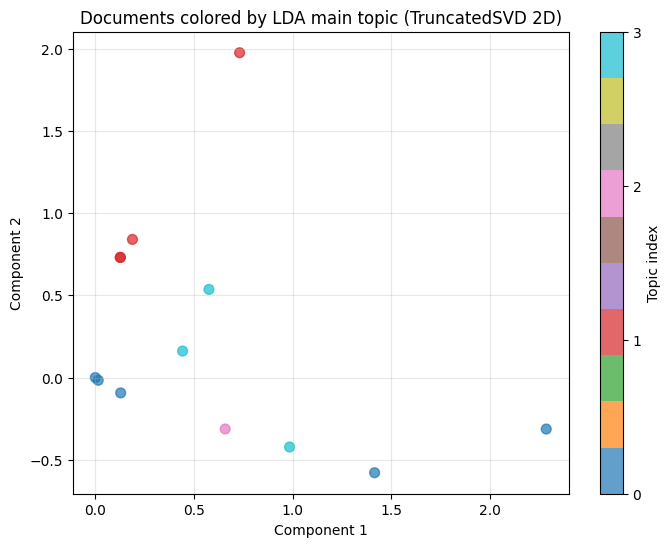

Done.


In [37]:
# -------- 2D visualization (TruncatedSVD for sparse matrices) --------
svd = TruncatedSVD(n_components=2, random_state=42)
dtm_2d = svd.fit_transform(dtm)

plt.figure(figsize=(8,6))
sc = plt.scatter(dtm_2d[:,0], dtm_2d[:,1], c=df['main_topic'], cmap='tab10', s=50, alpha=0.7)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Documents colored by LDA main topic (TruncatedSVD 2D)')
plt.colorbar(sc, ticks=range(N_TOPICS), label='Topic index')
plt.grid(alpha=0.3)
plt.show()
print("Done.")